In [9]:
import numpy as np
from tqdm import tqdm
import random
import gymnasium as gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import deque

In [10]:
#Setting up the environment
env = gym.make('Taxi-v3', render_mode='ansi')
state, _ = env.reset()

# The state of the environment
print(state)

print("decoded state")
print(list(env.decode(state)))


#The number of states in the environment
print(env.observation_space.n)

#The number of actions in the environment
print(env.action_space.n)

#Take a step in the environment
next_state, reward, done, _, _ = env.step(1)
print("decoded state")
print(list(env.decode(next_state)))

#Render the environment
env.render()

304
decoded state
[3, 0, 1, 0]
500
6
decoded state
[2, 0, 1, 0]


c:\Users\maste\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


'+---------+\n|\x1bR\x1b: | : :\x1bG\x1b|\n| : | : : |\n|\x1b \x1b: : : : |\n| | : | : |\n|Y| : |B: |\n+---------+\n  (North)\n'

[![Options](https://www.researchgate.net/publication/292208109/figure/fig2/AS:960497125978114@1606011768506/Taxi-problem-and-an-action-hierarchy.gif)]

In [11]:
goal_states = [[0, 0], [0, 4], [4, 0], [4, 3]]
# regions = [[[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]], [[0,4],[0,3],[0,2],[1,4],[1,3],[1,2],[2,4],[2,3],[2,2]], [[4,0],[3,0],[2,0],[2,1]], [[4,3],[4,4],[3,3],[3,4],[2,3],[2,4]]]
regions = [[[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[4,0]], [[0,4],[0,3],[0,2],[1,4],[1,3],[1,2],[2,4],[2,3],[2,2]], [[4,3],[4,4],[3,3],[3,4],[2,3],[2,4]]]

prim_actions = [0, 1, 2, 3, 4, 5]
# actions:  ['down', 'up', 'right', 'left', 'pickup', 'dropoff']

# options = [6, 7, 8, 9]
# options: ['goR', 'goG', 'goY', 'goB']
options = [6, 7, 8]
# options: ['goRY', 'goG', 'goB']

actions = prim_actions+options

# Softmax function
def softmax(Q, state, tau):
    q_values = Q[state]
    q_values = q_values / tau
    max_q = np.max(q_values)
    e = np.exp(q_values - max_q)
    dist = e / np.sum(e)
    action = np.random.choice(len(dist), p=dist)
    return action

def epsilon_greedy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, 4)
    else:
        action = np.argmax(Q[state])
    return action

In [12]:
def decode_state(env, state):
    return list(env.decode(state))

In [13]:
### HYPERPARAMETERS ###
ALPHA_Q = 0.1
ALPHA_OPTIONS = 0.25
ALPHA_OPTIONS_1 = 0.4
GAMMA = 0.99
TAU = 0.1
DECAY_CONSTANT = 0.995

In [14]:
def execute_option(env, state, option, Q_select_option, Q_within_option, select_opt_freq, within_opt_freq, policy=softmax):

    optdone = False

    if option < len(prim_actions):
        next_state, reward, done, _, _ = env.step(option)
        optdone = done
        optact = option
        Q_select_option[state][option] += ALPHA_Q * (reward + GAMMA * np.max(Q_select_option[next_state]) - Q_select_option[state][option])
        select_opt_freq[state][option] += 1
        return next_state, reward, done, [Q_select_option, Q_within_option, select_opt_freq, within_opt_freq]
        
    if option >= len(prim_actions):
        reward_bar = 0
        optnum = options.index(option)
        counter = 0
        current_state = state
        while optdone == False:
            optact = policy(Q_within_option[optnum], state, TAU)
            next_state, reward, done, _, _ = env.step(optact)
            reward_bar += reward * (GAMMA ** counter)
            if decode_state(env, next_state)[:2] in regions[optnum]:
                optdone = True
                Q_select_option[current_state, option] += ALPHA_Q * (reward_bar - Q_select_option[current_state, option] + GAMMA**counter * np.max(Q_select_option[next_state]))
                select_opt_freq[current_state, option] += 1
            REGION_REWARD = 30 if optdone else 0
            Q_within_option[optnum, state, optact] += ALPHA_OPTIONS * (reward + REGION_REWARD + GAMMA * np.max(Q_within_option[optnum, next_state]) - Q_within_option[optnum, state, optact])
            within_opt_freq[optnum, state, optact] += 1
            counter += 1
            state = next_state             
        return next_state, reward_bar, done, [Q_select_option, Q_within_option, select_opt_freq, within_opt_freq]

In [15]:
#### SMDP Q-Learning
episodes = 10000

def SMDP_Q_Learning(env, Q_values, Q_options, main_update_freq, option_update_freq, episodes, policy=softmax, TAU = TAU):
    # Iterate over 1000 episodes
    total_rewards = np.zeros((episodes))
    for i in tqdm(range(episodes)):
        state, _ = env.reset()    
        done = False
        # While episode is not over
        while not done:
            # Choose action        
            option = policy(Q_values, state, TAU)
            # Execute action
            next_state, reward, done, value_array = execute_option(env, state, option, Q_values, Q_options, main_update_freq, option_update_freq, policy=policy)
            Q_values, Q_options, main_update_freq, option_update_freq = value_array
            state = next_state
            total_rewards[i] += reward
        TAU = max(0.01, TAU * DECAY_CONSTANT)
    return Q_values, Q_options, main_update_freq, option_update_freq, total_rewards


In [16]:
all_rewards=[]
for i in range(5):
    Q_select_option = np.zeros((env.observation_space.n, len(actions)))
    Q_within_option = np.zeros((len(options), env.observation_space.n, len(prim_actions)-2))
    main_update_freq = np.zeros(Q_select_option.shape)
    option_update_freq = np.zeros(Q_within_option.shape)
    Q_select_option, Q_within_option, main_update_freq, option_update_freq, total_rewards = SMDP_Q_Learning(env, Q_select_option, Q_within_option, main_update_freq, option_update_freq, episodes, policy=softmax, TAU = TAU)
    all_rewards.append(total_rewards)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:19<00:00, 521.79it/s]


In [17]:
def plot_rewards(rewards):
    avg_rew = []
    std_dev = []
    plt.figure("Reward Plot")
    scores_window = deque(maxlen=100)
    for reward in rewards:
        scores_window.append(reward)
        avg_rew.append(np.mean(scores_window))
        std_dev.append(np.std(scores_window))
    plt.plot(avg_rew)
    plt.fill_between(range(len(avg_rew)), np.subtract(avg_rew, std_dev), np.add(avg_rew, std_dev), color='b', alpha=0.1)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.ylim(-500, 200)  # Set the Y-axis range


7.672310265821398


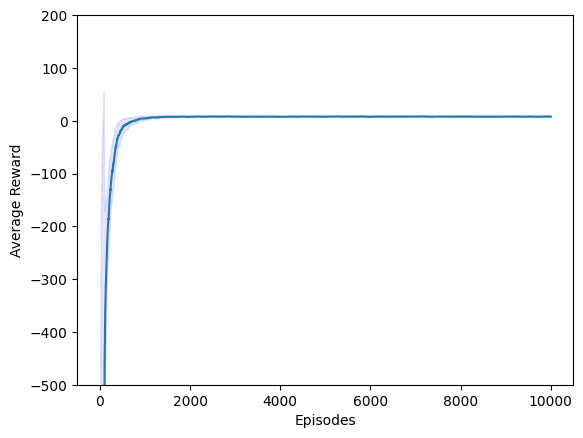

In [18]:
total_rewards = np.sum(np.array(all_rewards), axis=0)/5
plot_rewards(total_rewards)
print(np.mean(total_rewards[-100:]))

In [19]:
'''
Passenger IN TAXI => DESTINATION is the goal
'''
def plot_options(Q_option):
    PASSENGER_LOCATIONS = [0, 1, 2, 3, 4]
    PASSENGER_LOCATIONS_TEXT = ['R', 'G', 'Y', 'B', 'In Taxi']
    DESTINATIONS = [0, 1, 2, 3]
    DESTINATIONS_TEXT = ['R', 'G', 'Y', 'B']

    ACTIONS_OPTIONS = ['down', 'up', 'right', 'left', 'pickup', 'dropoff']

    fig, ax = plt.subplots(5, 4, figsize=(20, 20))

    for PASS_LOC in PASSENGER_LOCATIONS:
        for DEST in DESTINATIONS:
            Q_MAP = np.zeros((5, 5, 4))
            for i in range(5):
                for j in range(5):
                    state = ((5*i + j) * 5 + PASS_LOC) * 4 + DEST
                    Q_MAP[i, j] = Q_option[state]
            
            ax[int(PASS_LOC), int(DEST)].imshow(np.argmax(Q_MAP, axis=2), cmap='YlOrBr')
            ax[int(PASS_LOC), int(DEST)].set_title(f"Passenger: {PASSENGER_LOCATIONS_TEXT[int(PASS_LOC)]}, Destination: {DESTINATIONS_TEXT[int(DEST)]}")
            ax[int(PASS_LOC), int(DEST)].axis('off')

           
            ax[int(PASS_LOC), int(DEST)].axhline(y=2.38, xmin=-1, xmax=0.4, color='red', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.5, ymin=1, ymax=0.42, color='red', linewidth=5)
            
            ax[int(PASS_LOC), int(DEST)].axhline(y=2.5, xmin=1, xmax=0.42, color='green', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.6, ymin=1, ymax=0.42, color='green', linewidth=5)

            ax[int(PASS_LOC), int(DEST)].axhline(y=1.5, xmin=-1, xmax=0.38, color='yellow', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axhline(y=2.5, xmin=0.18, xmax=0.38, color='yellow', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=0.38, ymin=-1, ymax=0.4, color='yellow', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.38, ymin=0.4, ymax=0.6, color='yellow', linewidth=5)

            ax[int(PASS_LOC), int(DEST)].axhline(y=1.5, xmin=1, xmax=0.62, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=2.54, ymin=0, ymax=0.58, color='blue', linewidth=5)

            ax[int(PASS_LOC), int(DEST)].axvline(x=0.5, ymin=-1, ymax=0.4, color='black', linewidth=2)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.54, ymin=1, ymax=0.6, color='black', linewidth=2)
            ax[int(PASS_LOC), int(DEST)].axvline(x=2.46, ymin=-1, ymax=0.4, color='black', linewidth=2)

            for i in range(5):
                for j in range(5):
                    state = (5*i + j)*4 + int(PASS_LOC)*4 + int(DEST)
                    anno = ACTIONS_OPTIONS[np.argmax(Q_MAP[i,j])]
                    size='medium'
                    ax[int(PASS_LOC), int(DEST)].text(j , i, anno, ha='center', va='center', color='black', size=size)

    plt.show()

def plot_Q_values(Q_values):
    
    PASSENGER_LOCATIONS = [0, 1, 2, 3, 4]
    PASSENGER_LOCATIONS_TEXT = ['R', 'G', 'Y', 'B', 'In Taxi']
    DESTINATIONS = [0, 1, 2, 3]
    DESTINATIONS_TEXT = ['R', 'G', 'Y', 'B']

    # ACTIONS_OPTIONS = ['down', 'up', 'right', 'left', 'pickup', 'dropoff', 'toR', 'toG', 'toY', 'toB']
    ACTIONS_OPTIONS = ['down', 'up', 'right', 'left', 'pickup', 'dropoff', 'goRY', 'goG', 'goB']


    fig, ax = plt.subplots(5, 4, figsize=(20, 20))

    for PASS_LOC in PASSENGER_LOCATIONS:
        for DEST in DESTINATIONS:
            Q_MAP = np.zeros((5, 5, len(ACTIONS_OPTIONS)))
            for i in range(5):
                for j in range(5):
                    state = ((5*i + j) * 5 + PASS_LOC) * 4 + DEST
                    Q_MAP[i, j] = Q_values[state]
            
            ax[int(PASS_LOC), int(DEST)].imshow(np.argmax(Q_MAP, axis=2), cmap='YlOrBr')
            ax[int(PASS_LOC), int(DEST)].set_title(f"Passenger: {PASSENGER_LOCATIONS_TEXT[int(PASS_LOC)]}, Destination: {DESTINATIONS_TEXT[int(DEST)]}")
            ax[int(PASS_LOC), int(DEST)].axis('off')

          
            ax[int(PASS_LOC), int(DEST)].axhline(y=2.38, xmin=-1, xmax=0.4, color='red', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.5, ymin=1, ymax=0.42, color='red', linewidth=5)
            
            ax[int(PASS_LOC), int(DEST)].axhline(y=2.5, xmin=1, xmax=0.42, color='green', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.6, ymin=1, ymax=0.42, color='green', linewidth=5)

            ax[int(PASS_LOC), int(DEST)].axhline(y=1.5, xmin=-1, xmax=0.38, color='yellow', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axhline(y=2.5, xmin=0.18, xmax=0.38, color='yellow', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=0.38, ymin=-1, ymax=0.4, color='yellow', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.38, ymin=0.4, ymax=0.6, color='yellow', linewidth=5)

            ax[int(PASS_LOC), int(DEST)].axhline(y=1.5, xmin=1, xmax=0.62, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=2.54, ymin=0, ymax=0.58, color='blue', linewidth=5)

            ax[int(PASS_LOC), int(DEST)].axvline(x=0.5, ymin=-1, ymax=0.4, color='black', linewidth=2)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.54, ymin=1, ymax=0.6, color='black', linewidth=2)
            ax[int(PASS_LOC), int(DEST)].axvline(x=2.46, ymin=-1, ymax=0.4, color='black', linewidth=2)

            for i in range(5):
                for j in range(5):
                    state = (5*i + j)*4 + int(PASS_LOC)*4 + int(DEST)
                    anno = ACTIONS_OPTIONS[np.argmax(Q_MAP[i,j])]
                    size='medium'
                    ax[int(PASS_LOC), int(DEST)].text(j , i, anno, ha='center', va='center', color='black', size=size)

    plt.show()


# Option Policy Plots

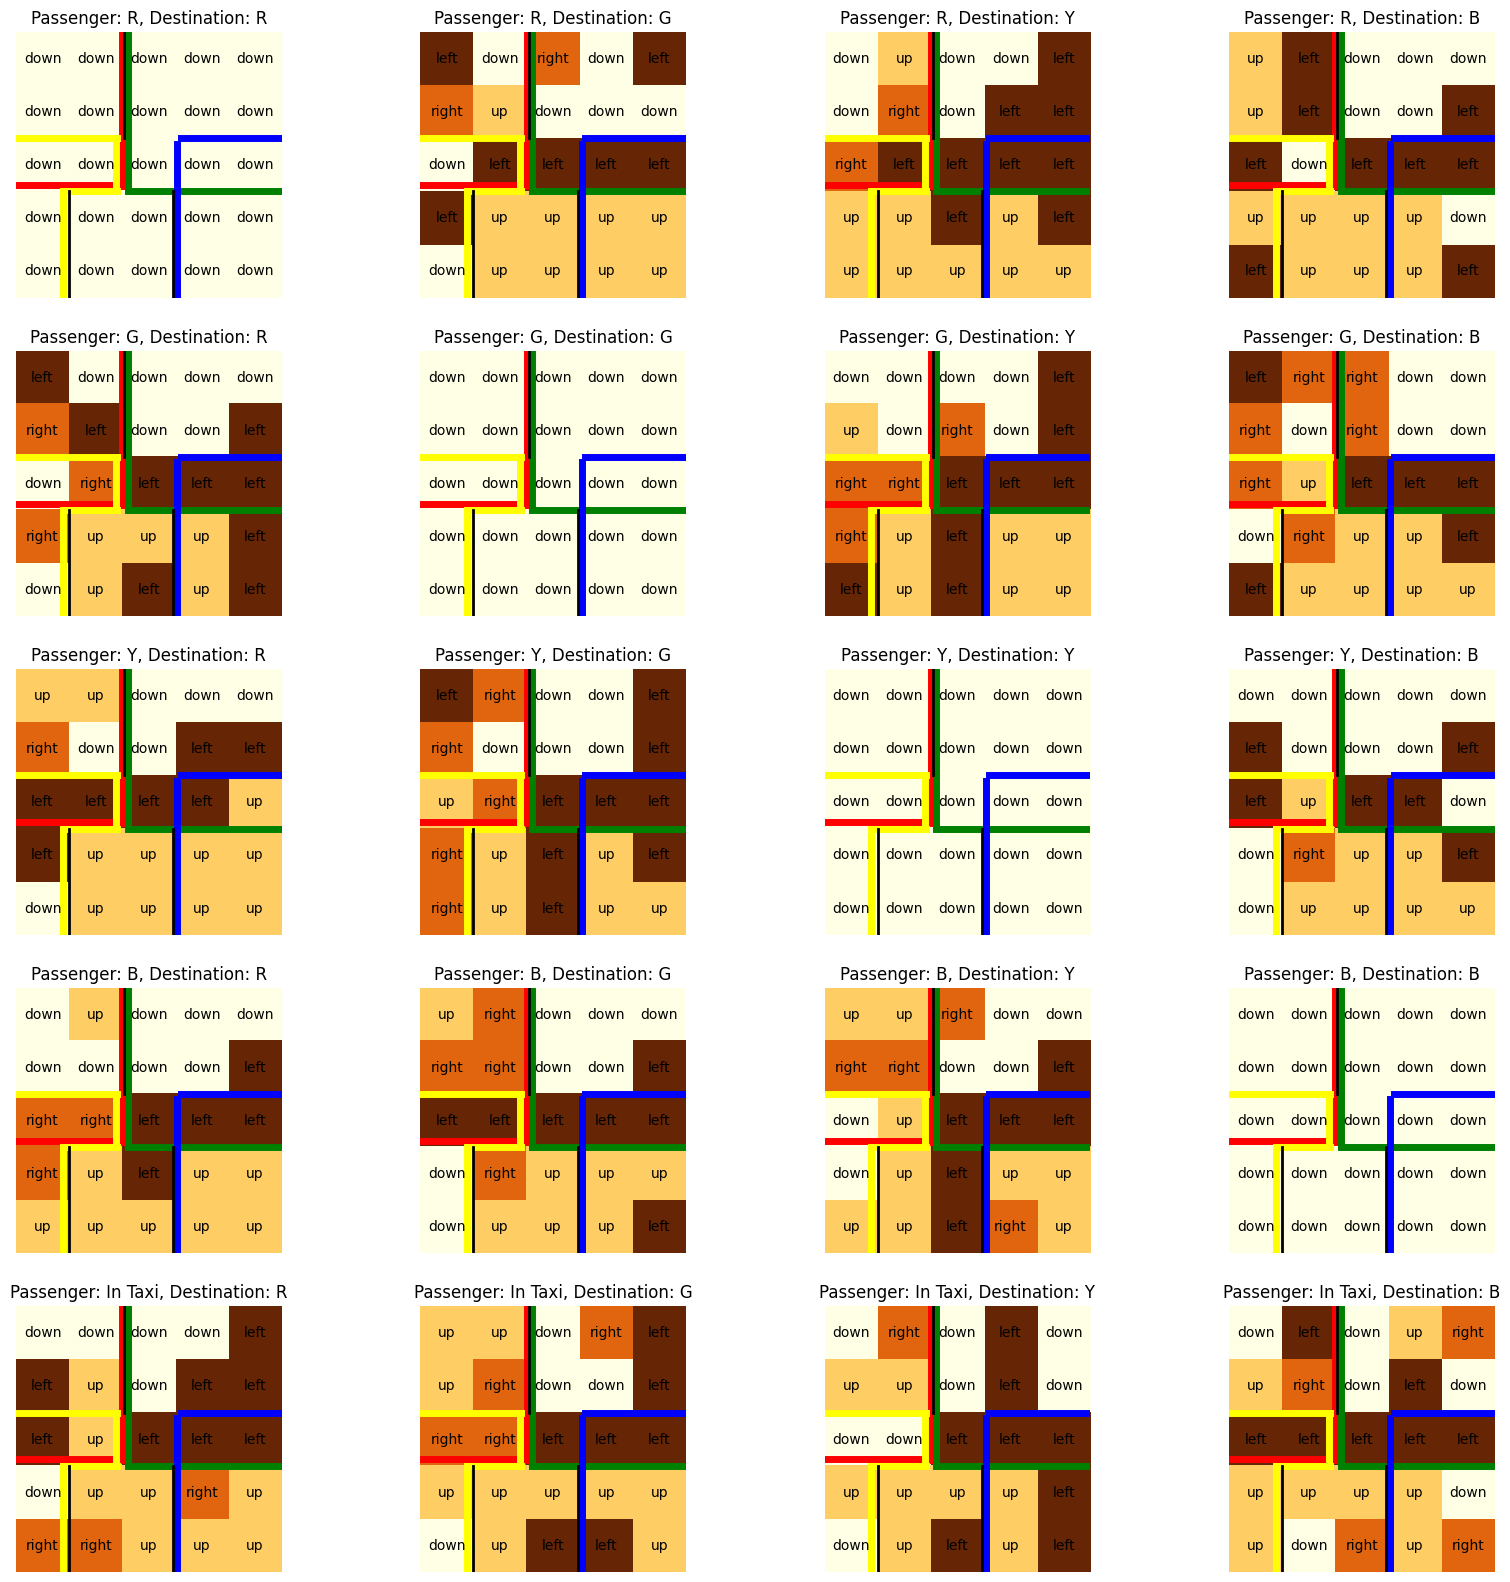

In [20]:
plot_options(Q_within_option[0])

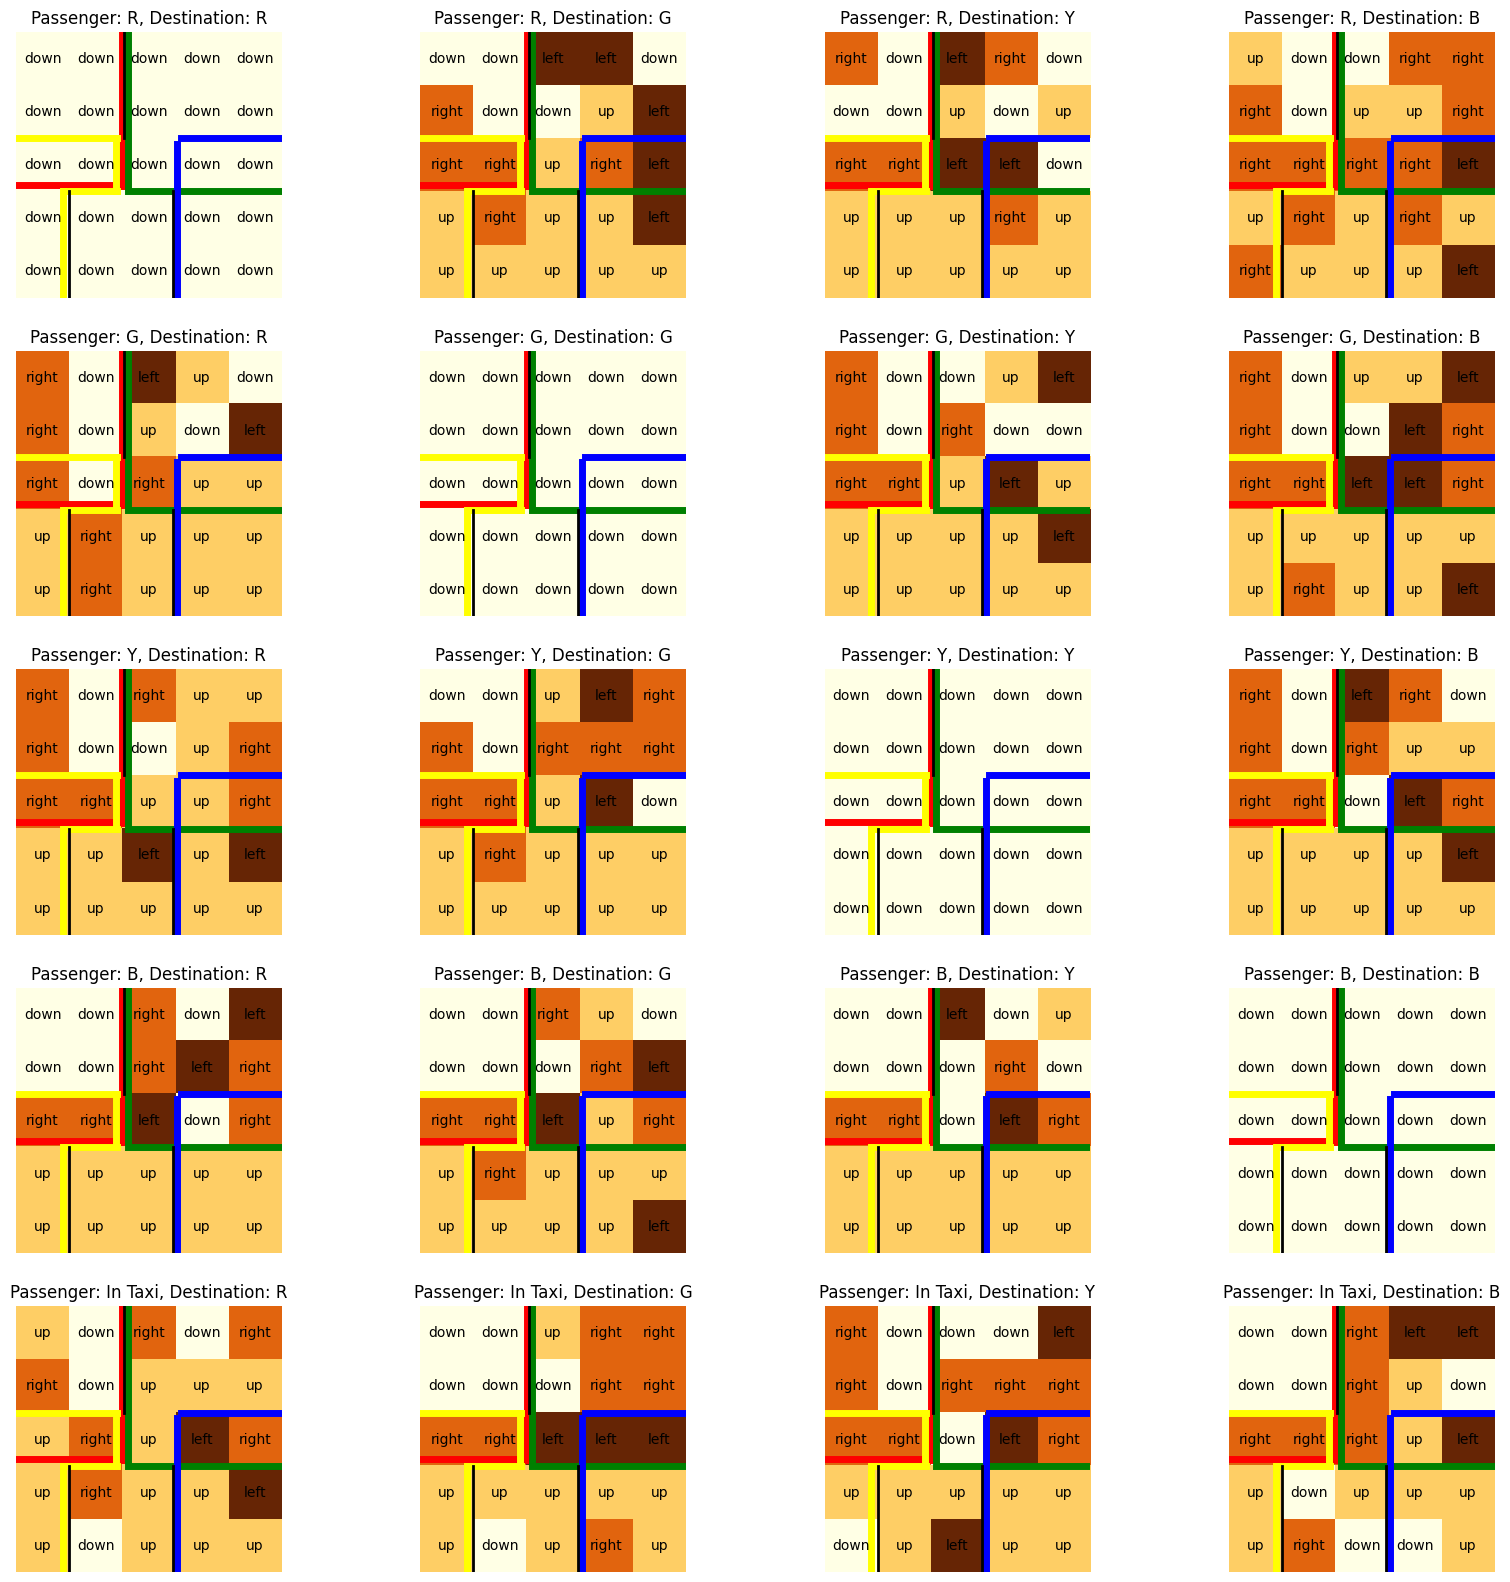

In [21]:
plot_options(Q_within_option[1])

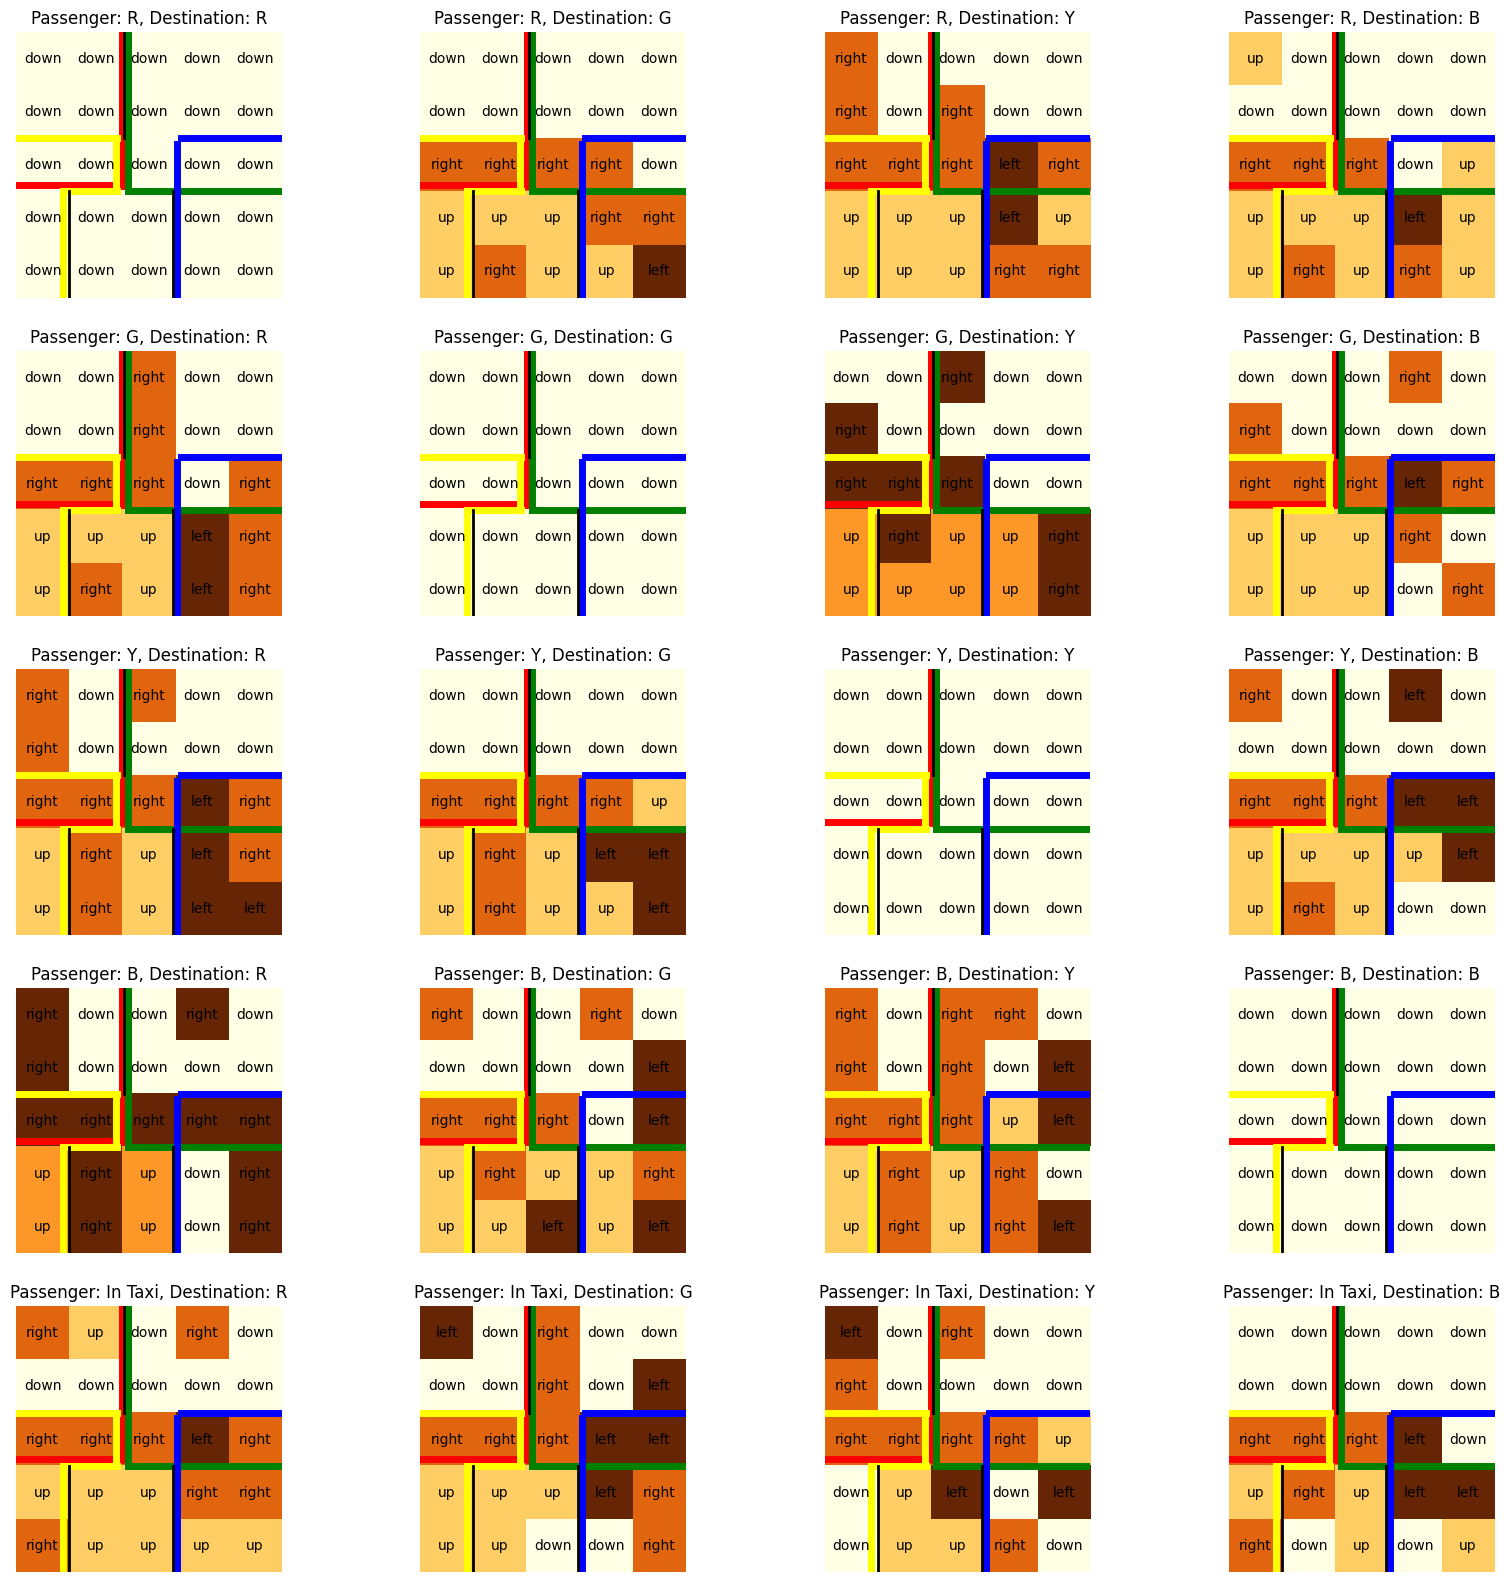

In [22]:
plot_options(Q_within_option[2])

In [23]:
plot_options(Q_within_option[3])

IndexError: index 3 is out of bounds for axis 0 with size 3

# Main Policy Plots

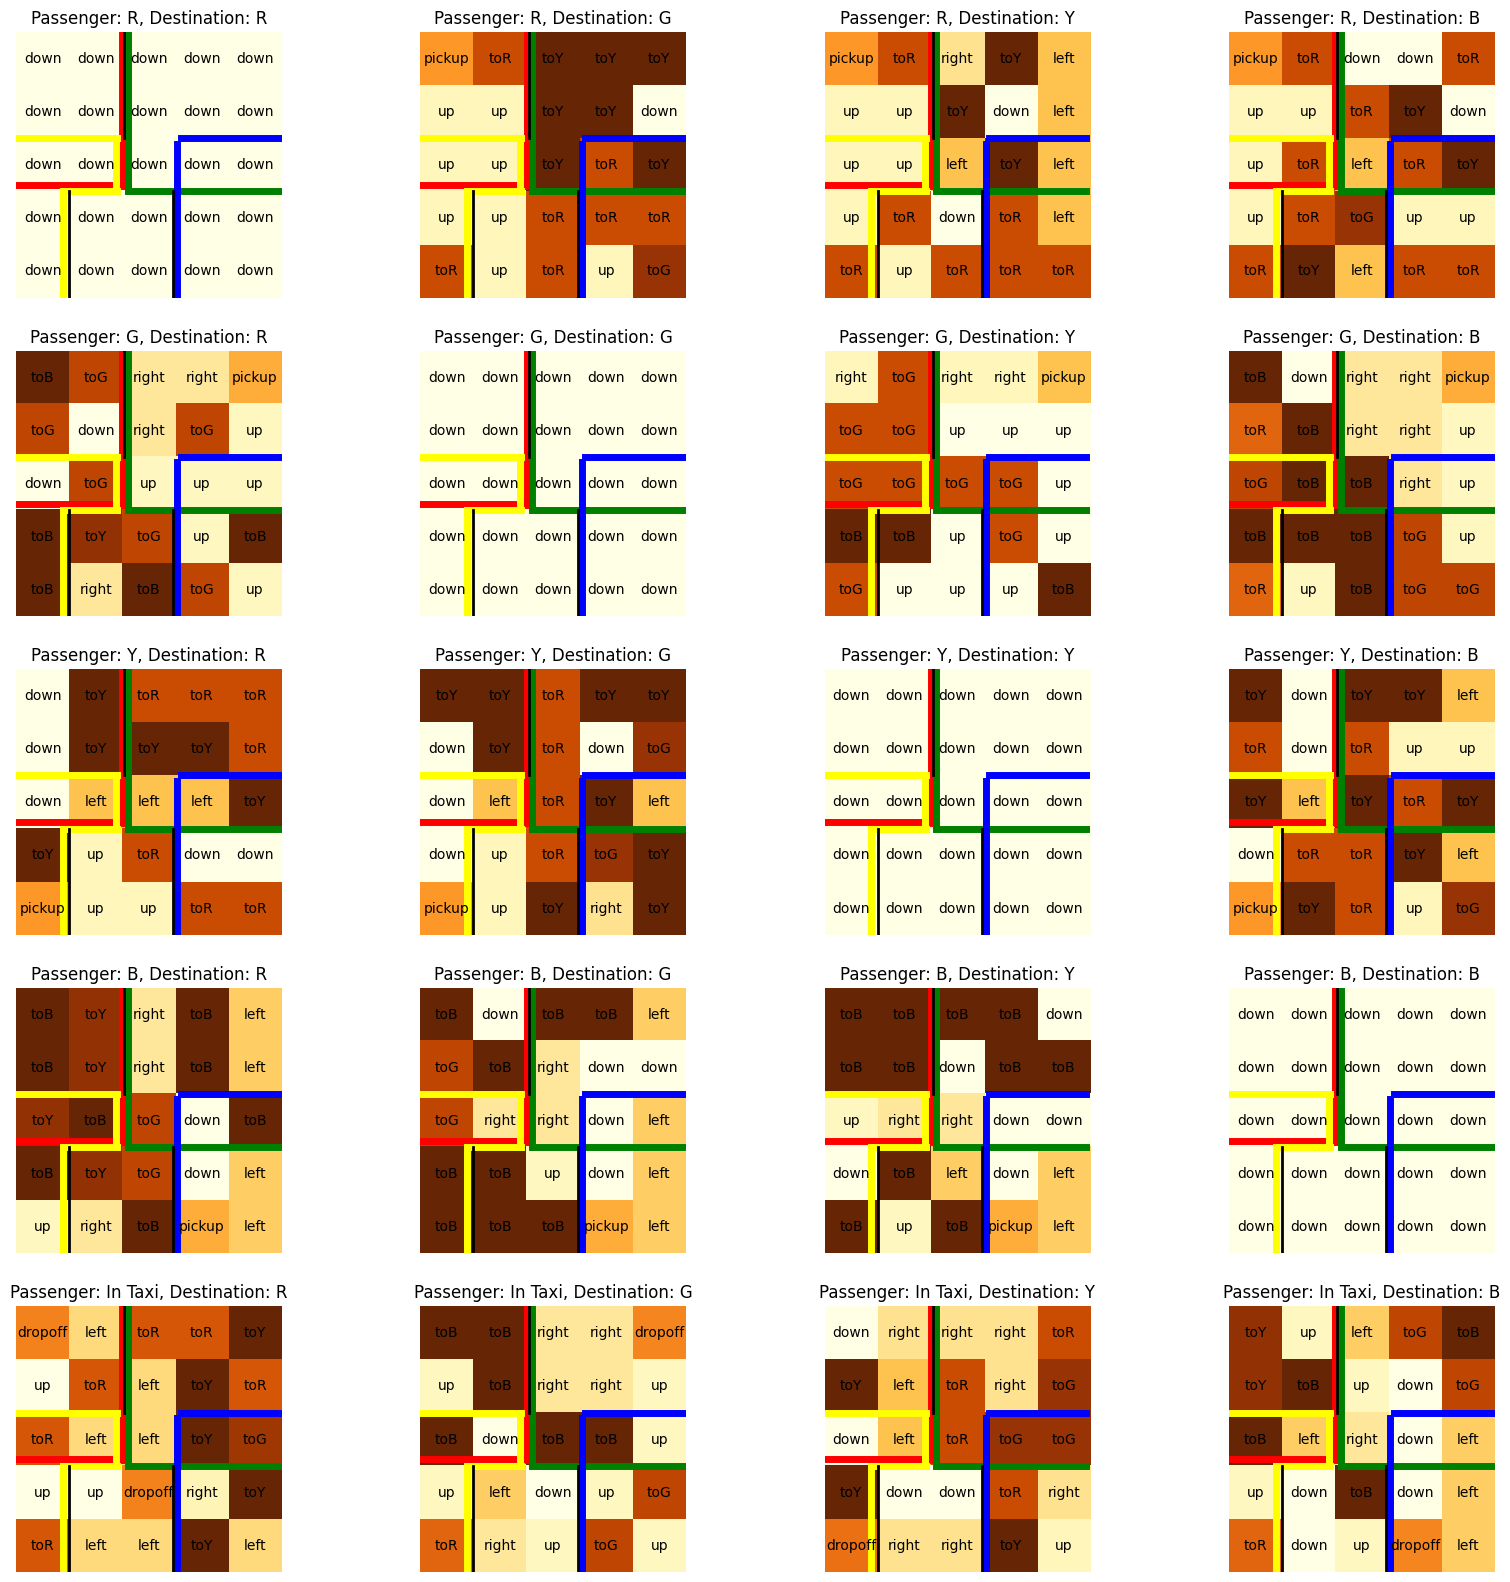

In [ ]:
plot_Q_values(Q_select_option)